# Assignment 5: RNNs
We are going to implement the following RNN for MNIST classification via various recurrent units.
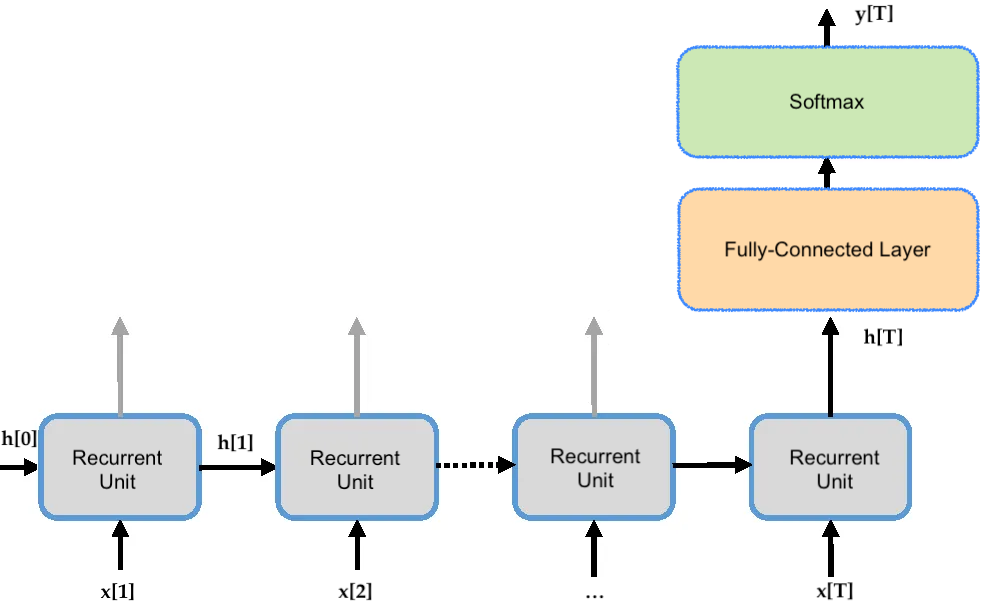


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader 

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
batch_size = 50
# transformations
transform = transforms.Compose([transforms.ToTensor()])
# load training dataset
trainset = MNIST(root='./data', train=True,
download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# load test dataset
testset = MNIST(root='./data', train=False,
download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [17]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

## Question 1: Implementing Basic RNN
We implement the RNN via basic Recurrent Unit.

### Task 1: Building our Model 

In [18]:
class myRNN(nn.Module):
    def __init__(self, batch_size):
        super(myRNN, self).__init__()
        self.h_size = 150
        self.time = 28
        self.x_size = 28
        self.y_size = 10
        
        # we need batch-size
        # since we should make same-size for initial state
        self.batch_size = batch_size

        self.RecUnit = nn.RNN(input_size=self.x_size, hidden_size=self.h_size, batch_first=True)
        # don't forget setting: batch_first = True

        self.output_layer = nn.Linear(self.h_size, self.y_size)
        
    def initial_state(self):
        return torch.zeros(1, self.batch_size, self.h_size)

    def forward(self, x):
        h_0 = self.initial_state().to(device)
        out, hn = self.RecUnit(x, h_0)
        
        y = self.output_layer(out[:, -1, :])

        return y







### Task 2: Write Accuracy Function

In [19]:
def accuracy(z_out, labels):
    # z_out and labels are both a mini-batch
    _, predicted = torch.max(z_out, 1)
    correct_pred = (predicted == labels).float().sum()
    accuracy = 100.0 * (correct_pred / len(labels))
    return accuracy.item()

## To confirm that the implementation returns correct dimensions, the confirmation process is shown as below

In [26]:
model = myRNN(batch_size).to(device)
for i, data in enumerate(trainloader):
    test_data = data.copy()
    inputs, labels = test_data
    inputs = inputs.to(device) 
    labels = labels.to(device)
    inputs = inputs.view(-1, 28, 28)
    y = model(inputs)

print(y[:,-1].shape)
print(labels.shape)
    


torch.Size([50])
torch.Size([50])


### Task 3: Implement Training Loop

In [58]:
def train(model, loss_function, num_epochs, trainloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs): 
        model.to(device)
        
        train_loss = 0.0
        train_accuracy = 0.0
        
        # training loop
        for i, data in enumerate(trainloader):
            model.train()
            # reset initial states
            #h_state = model.initial_state().to(device)

            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # reshape input
            inputs = inputs.view(-1, 28, 28)

            # forward pass
            outputs = model(inputs)

            # compute loss
            loss = loss_function(outputs, labels)

            # backward pass
            loss.backward()
            optimizer.step()

            
            # update training loss and accuracy
            train_loss += loss.item()
            train_accuracy += accuracy(outputs, labels)

        model.eval()
        print(f'Epoch:{epoch+1}|Loss:{train_loss/ (i+1):.4f}|Accuracy:{train_accuracy / (i+1):.2f}%')
    return

and now we can train

In [59]:
# Instantiate model
model = myRNN(batch_size)
loss_function = nn.CrossEntropyLoss()
num_epochs = 10
# complete
train(model, loss_function, num_epochs, trainloader)

Epoch:1|Loss:14.3559|Accuracy:10.43%
Epoch:2|Loss:32.1897|Accuracy:9.67%
Epoch:3|Loss:34.5967|Accuracy:10.13%
Epoch:4|Loss:57.5541|Accuracy:9.97%
Epoch:5|Loss:55.6992|Accuracy:10.73%
Epoch:6|Loss:66.0955|Accuracy:10.10%
Epoch:7|Loss:97.8226|Accuracy:8.27%
Epoch:8|Loss:110.3985|Accuracy:9.38%
Epoch:9|Loss:75.9872|Accuracy:8.41%
Epoch:10|Loss:75.1714|Accuracy:8.41%


## Question 2: Implementing RNN with Gated Unit
We now replace basic recurrent unit with a GRU.

### Task 1: Building RNN with GRU

In [66]:
class myGatedRNN(nn.Module):
    def __init__(self, batch_size):
        super(myGatedRNN, self).__init__()
        self.h_size = 150
        self.time = 28
        self.x_size = 28
        self.y_size = 10

        # we need batch-size
        # since we should make same-size for initial state
        self.batch_size = batch_size

        self.RecUnit = nn.GRU(input_size=self.x_size, hidden_size=self.h_size, batch_first=True)
        # don't forget setting: batch_first = True

        self.output_layer = nn.Linear(self.h_size, self.y_size)
    def initial_state(self):
        return torch.zeros(1, self.batch_size, self.h_size)

    def forward(self, x):
        h_0 = self.initial_state().to(device)
        y, h_n = self.RecUnit(x, h_0)
        y = self.output_layer(y[:, -1, :])

        return y

### Task 2: Train Gated RNN

In [67]:
# Instantiate model
model = myGatedRNN(batch_size)
loss_function = nn.CrossEntropyLoss()

# complete
num_epochs = 10
trained_model = train(model, loss_function, num_epochs, trainloader)

Epoch:1|Loss:2.4788|Accuracy:42.13%
Epoch:2|Loss:14.4238|Accuracy:17.48%
Epoch:3|Loss:20.3323|Accuracy:15.17%
Epoch:4|Loss:20.6344|Accuracy:16.52%
Epoch:5|Loss:23.3836|Accuracy:14.98%
Epoch:6|Loss:26.1192|Accuracy:16.28%
Epoch:7|Loss:27.8957|Accuracy:15.64%
Epoch:8|Loss:29.6969|Accuracy:13.94%
Epoch:9|Loss:29.3980|Accuracy:17.93%
Epoch:10|Loss:30.4507|Accuracy:19.98%


# Comments
From GRU implementation, we could observe the increase in prediction accuraices. To be noticed, the first epoch shows better performance compared to the later epochs, and this may be due to the overfitting problem.

## Question 3: Implementing RNN with LSTM
We now replace basic recurrent unit with an LSTM.

### Task 1: Building RNN with LSTM

In [64]:
class myLSTM(nn.Module):
    def __init__(self, batch_size):
        super(myLSTM, self).__init__()
        self.h_size = 150
        self.time = 28
        self.x_size = 28
        self.y_size = 10

        # we need batch-size
        # since we should make same-size for initial state
        self.batch_size = batch_size


        self.RecUnit = nn.LSTM(input_size=self.x_size, hidden_size=self.h_size, 
                               batch_first=True)
        # don't forget setting: batch_first = True

        self.output_layer = nn.Linear(self.h_size, self.y_size)
    def initial_state(self):
        h0 = torch.zeros(1, self.batch_size, self.h_size)
        c0 = torch.zeros(1, self.batch_size, self.h_size)

        return h0, c0

    def forward(self, x):

        h0, c0 = self.initial_state()
        h0 = h0.to(device)
        c0 = c0.to(device)
        lstm_out, (hn, cn) = self.RecUnit(x, (h0, c0))
        lstm_out = lstm_out[:, -1, :]


        y = self.output_layer(lstm_out)
        return y

### Task 2: Train LSTM

In [65]:
# Instantiate model
model = myLSTM(batch_size)
loss_function = nn.CrossEntropyLoss()

# complete
num_epochs = 10
trained_model = train(model, loss_function, num_epochs, trainloader)

Epoch:1|Loss:1.4212|Accuracy:48.78%
Epoch:2|Loss:0.8826|Accuracy:70.51%
Epoch:3|Loss:1.1800|Accuracy:63.01%
Epoch:4|Loss:2.5566|Accuracy:33.51%
Epoch:5|Loss:2.1941|Accuracy:29.51%
Epoch:6|Loss:2.2957|Accuracy:26.01%
Epoch:7|Loss:2.2098|Accuracy:25.99%
Epoch:8|Loss:2.1285|Accuracy:24.52%
Epoch:9|Loss:2.0777|Accuracy:29.68%
Epoch:10|Loss:2.3411|Accuracy:24.51%


# Comments
The overall performance of LSTM is much better than simple RNNs and GRU. However, similar attenuation in performance could be observed from the implementation. This may be due to the overfitting problem because we did not implement dropout or batch normalization techniques in ths structure.